In [71]:
import pandas as pd
import numpy as np

from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm import tqdm

# Бутстрап

Обладая только данными по имеющейся выборке, бутстрап позволяет оценить любой ее параметр, построив эмпирическое распределение параметра<br>
- Бутстрап позволяет брать доверительные интервалы из сложных параметров без использования формулы, например, из медианы
    - у медиан есть проблема смещения
- Бутстрап проверяет статистические гипотезы без опоры на определенное теоретическое распределение данных, поэтому он не требует соблюдения предположений классических стат критериев
- Бутстрап позволяет более точно оценивать разницу между выборками. Можно понять, в какой именно части распределения есть разница.
    - Это можно узнать через сравнение перцентилей

### Как брать подвыборки в Бутстрапе?
- Подвыборки берутся с возвращением
    - То есть после каждого выбрра случайного параметра он как бы возвращается на место, чтобы была возможность взять его снова
- Всегда берутся подвыборки такого же размера как и сама выборка, чтобы сохранить дисперсию, которая по формуле использует n

### Проблема смещения
В отличие от среднего, другие параметры могут быть сильно подвержены смещенной оценке значения параметра генеральной совокупности (хотя само среднее тоже не исключение). <br><b><i>Если статистика не среднее, то она сильно подвержена смещению, которое необходимо корректировать.</b></i>

##### Как считаем смещение
1. Считаем разницу исследуемой метрики между исходными группами
2. Считаем разницы исследуемой метрики между бутстрапированными группами для каждой бут-итерации
    - Считаем среднее по дельте бут-выборок
3. Считаем дельту сдвига между исходной и бут-дельтой
4. Для каждого значения бут-дельты (из п. 2) добавляем дельту сдвига

### Проверка гиптез с помощью бутстрапа

1. Расчет интервал для доли
2. Через p-value
    - p value - это по сути площадь под кривой и это же false positive <br>`(cdf в scipy от нормального распределения)`
3. На каждой итерации бутстрапа считаем t статистику, считаем из этого p-value
4. Считаем дельты и из них среднее и ско. считаем площадь под кривой

In [68]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_0: list, # числовые значения первой выборки
    data_1: list, # числовые значения второй выборки
    boot_it: int = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    conf_level: float = 0.95, # уровень значимости,
    ba: bool = False
):
    
    df = pd.DataFrame({
        'x': data_0,
        'y': data_1
    })
    
    boot_data = []
    for _ in tqdm(range(boot_it)): # извлекаем подвыборки
        boot_0 = df.x.sample(len(data_0), replace = True).values
        boot_1 = df.y.sample(len(data_1), replace = True).values
        boot_data.append(statistic(boot_0) - statistic(boot_1)) # mean() - применяем статистику
        
    # поправляем смещение
    if ba:
        orig_theta = statistic(data_0)-statistic(data_1) # разница в исходных данных
        boot_theta = np.mean(boot_data) # среднее по бутстрапированной разнице статистик
        delta_val = abs(orig_theta - boot_theta) # дельта для сдвига
        boot_data = [i + delta_val for i in boot_data] # сдвигаем бут разницу статистик, обратите внимание, что тут не вычитание
        print(f"""
            До бутстрапа: {orig_theta},
            После бутстрапа: {boot_theta},
            После коррекции: {np.mean(boot_data)}"""
        )

    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd.DataFrame(boot_data).quantile([left_quant, right_quant])

    # p-value
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd.DataFrame(boot_data)[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data statistics": statistic(boot_data), 
            "ci": ci, 
            "p_value": p_value}

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2967.10it/s]



            До бутстрапа: -0.006141018251564878,
            После бутстрапа: -0.006673841472269853,
            После коррекции: -0.00614101825156488


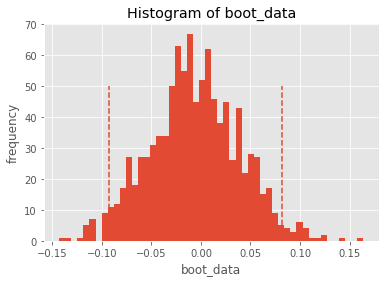

{'boot_data statistics': -0.00614101825156488,
 'ci':               0
 0.025 -0.092682
 0.975  0.081479,
 'p_value': 0.891750090117413}

In [69]:
get_bootstrap(
    np.random.exponential(size=1000),
    np.random.exponential(size=1000)*1.01,
    ba=True
)

In [105]:
print(left_quant, right_quant)

0.025000000000000022 0.975


In [106]:
ci

,0
0.025,-0.112359
0.975,0.064979


In [113]:
p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
print(p_1, p_2)

0.9999740504413371 2.5949558662896338e-05


In [114]:
p_value = min(p_1, p_2) * 2
p_value

5.1899117325792676e-05

### Для оптимизации можно бить юзеров на бакеты
- Для бутстрап-выборок нужно задавать размер такой же, как и у изначальной выборки
- Начиная с ~1 млн наблюдений начинаются проблемы, связанные со скоростью вычисления
> Поэтому аудиторию правильнее бить на бакеты

#### Сгенерим данные

In [78]:
b_n = 5000
n = int(1e7)

val_1 = np.random.exponential(scale=1/0.01, size=n)
val_2 = np.random.exponential(scale=1/0.011, size=n)

sample_exp = pd.DataFrame({
    "values":   np.concatenate([val_1, val_2]),  
    "variant":  ["A" for i in range(n)] + ["B" for i in range(n)],
    "bucket":   [i for i in range(b_n)] * int(n*2/b_n)
})

sample_exp.head()

,values,variant,bucket
0,204.782480,A,0
1,42.008704,A,1
2,137.334623,A,2
3,86.573417,A,3
4,124.988038,A,4


#### Бутстрапирование до бакетирования

100%|███████████████████████████████████████| 1000/1000 [29:40<00:00,  1.78s/it]



            До бутстрапа: 9.072580724322378,
            После бутстрапа: 9.07116779477907,
            После коррекции: 9.072580724322377


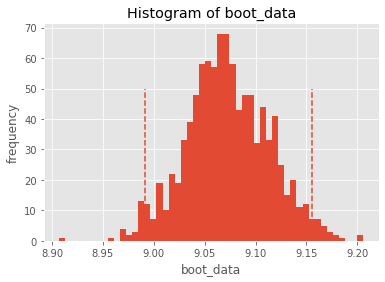

{'boot_data statistics': 9.072580724322377,
 'ci':               0
 0.025  8.991713
 0.975  9.154989,
 'p_value': 0.0}

In [101]:
 get_bootstrap(
    sample_exp[sample_exp.variant == 'A']['values'].values,
    sample_exp[sample_exp.variant == 'B']['values'].values,
    ba=True
)

#### Бутстрапирование после бакетирования
> Как мы видим, при бакетировании результаты практически не изменились, а скорость значительно возрасла

In [96]:
sample_exp_bucketed = sample_exp.groupby(['bucket','variant'])[['values']].mean().reset_index()
sample_exp_bucketed.head()

,bucket,variant,values
0,0,A,104.892746
1,0,B,91.381837
2,1,A,103.344684
3,1,B,93.859043
4,2,A,99.999871


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1490.80it/s]



            До бутстрапа: 9.07258072432245,
            После бутстрапа: 9.0748103993853,
            После коррекции: 9.077040074448151


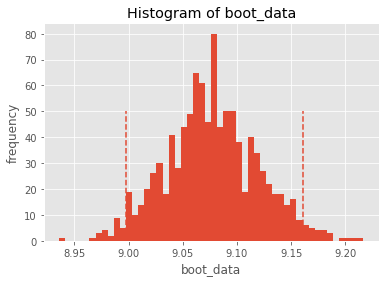

{'boot_data statistics': 9.077040074448151,
 'ci':               0
 0.025  8.997863
 0.975  9.161184,
 'p_value': 0.0}

In [100]:
 get_bootstrap(
    sample_exp_bucketed[sample_exp_bucketed.variant == 'A']['values'].values,
    sample_exp_bucketed[sample_exp_bucketed.variant == 'B']['values'].values,
    ba=True
)